# Küresel Isınma ve İklim Değişikliği Analizi - Climate Change and Global Warming Analysis

In [6]:
# Gerekli kütüphaneleri içe aktar / Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from prophet import Prophet
import shap

In [7]:
# Grafik ayarları / Plot settings
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (14, 6)

In [10]:
df = pd.read_csv("GlobalTemperatures.csv")


In [12]:
df["dt"] = pd.to_datetime(df["dt"])
df.rename(columns={"dt": "Date", "LandAverageTemperature": "AvgTemp"}, inplace=True)
df["Year"] = df["Date"].dt.year
df["Month"] = df["Date"].dt.month

In [14]:
# Eksik verileri kontrol et / Check missing values
print("Eksik Değerler / Missing Values:\n", df.isnull().sum())

Eksik Değerler / Missing Values:
 Date                                            0
AvgTemp                                        12
LandAverageTemperatureUncertainty              12
LandMaxTemperature                           1200
LandMaxTemperatureUncertainty                1200
LandMinTemperature                           1200
LandMinTemperatureUncertainty                1200
LandAndOceanAverageTemperature               1200
LandAndOceanAverageTemperatureUncertainty    1200
Year                                            0
Month                                           0
dtype: int64


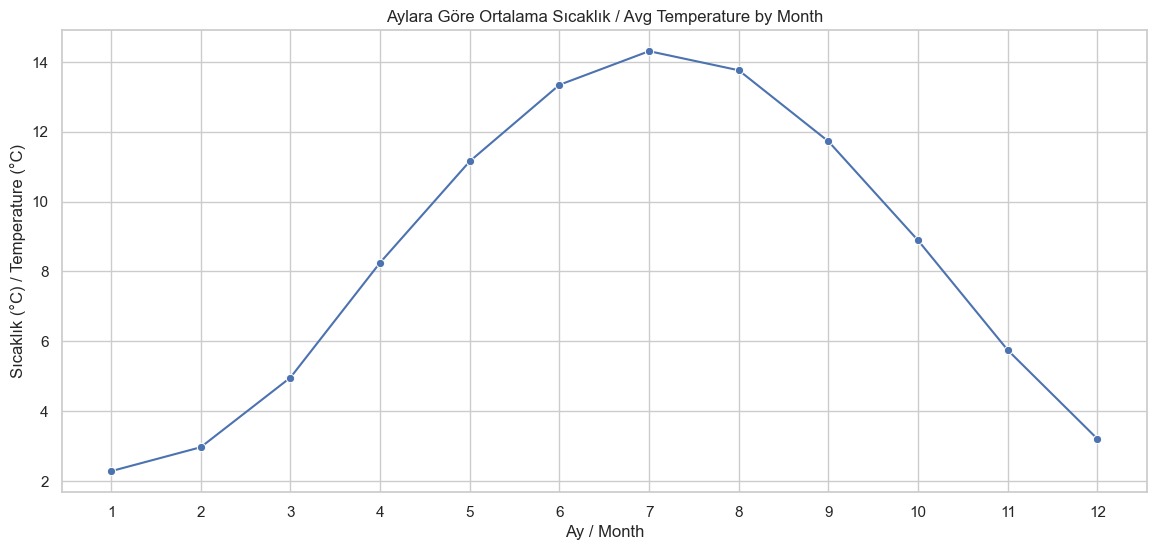

In [24]:
# Aylık Ortalama Sıcaklık / Monthly Average Temperature
monthly_avg = df.groupby("Month")["AvgTemp"].mean()
sns.lineplot(x=monthly_avg.index, y=monthly_avg.values, marker="o")
plt.title("Aylara Göre Ortalama Sıcaklık / Avg Temperature by Month")
plt.xlabel("Ay / Month")
plt.ylabel("Sıcaklık (°C) / Temperature (°C)")
plt.xticks(np.arange(1, 13))
plt.grid(True)
plt.show()


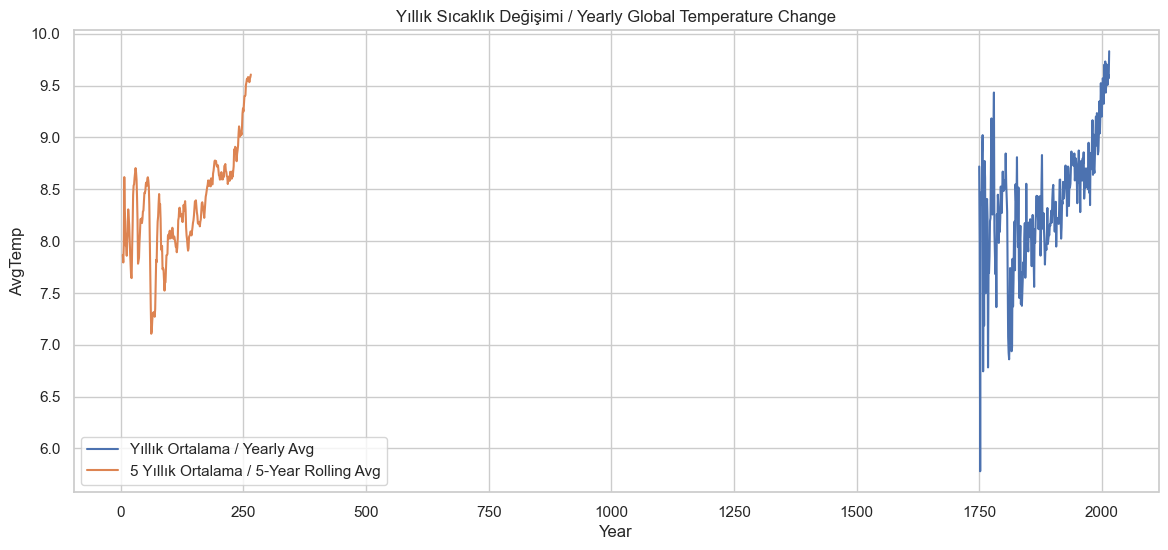

In [25]:
# Yıllık Trend ve Hareketli Ortalama / Yearly Trend & Rolling Avg
yearly = df.groupby("Year")["AvgTemp"].mean().reset_index()
sns.lineplot(data=yearly, x="Year", y="AvgTemp", label="Yıllık Ortalama / Yearly Avg")
sns.lineplot(data=yearly["AvgTemp"].rolling(5).mean(), label="5 Yıllık Ortalama / 5-Year Rolling Avg")
plt.title("Yıllık Sıcaklık Değişimi / Yearly Global Temperature Change")
plt.legend()
plt.show()

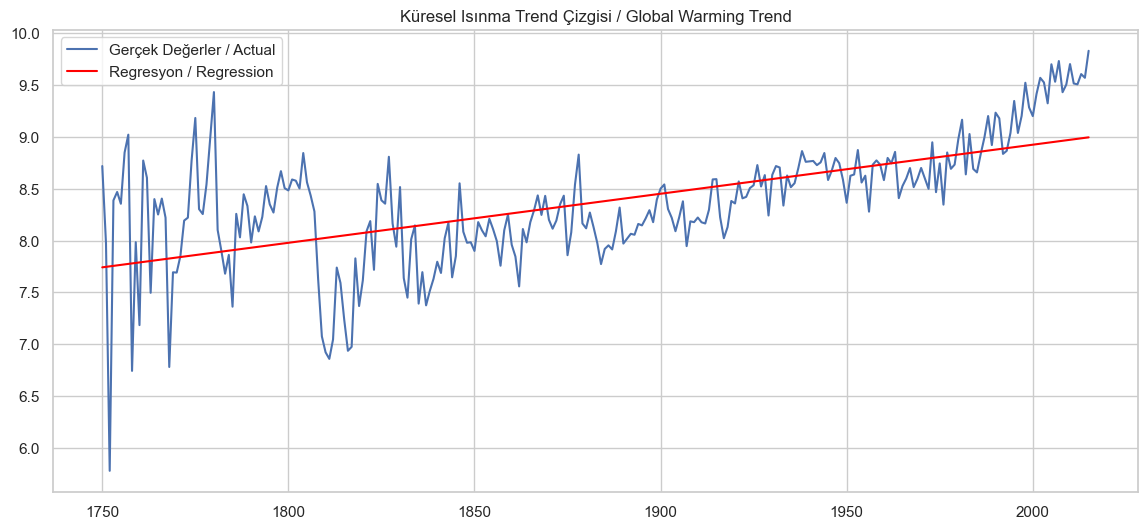

In [26]:
#  Doğrusal Regresyon ile Trend / Linear Regression Trend
X = yearly["Year"].values.reshape(-1, 1)
y = yearly["AvgTemp"].values
reg = LinearRegression()
reg.fit(X, y)
y_pred = reg.predict(X)

plt.plot(yearly["Year"], y, label="Gerçek Değerler / Actual")
plt.plot(yearly["Year"], y_pred, color="red", label="Regresyon / Regression")
plt.title("Küresel Isınma Trend Çizgisi / Global Warming Trend")
plt.legend()
plt.show()

In [28]:
print(f"Yıllık sıcaklık artış tahmini / Estimated yearly temperature increase: {reg.coef_[0]:.4f} °C")


Yıllık sıcaklık artış tahmini / Estimated yearly temperature increase: 0.0047 °C


In [29]:
# En Sıcak & Soğuk Yıllar / Hottest & Coldest Years
top_hot = yearly.sort_values(by="AvgTemp", ascending=False).head(10)
top_cold = yearly.sort_values(by="AvgTemp", ascending=True).head(10)
print("En Sıcak 10 Yıl / Top 10 Hottest Years:\n", top_hot)
print("En Soğuk 10 Yıl / Top 10 Coldest Years:\n", top_cold)


En Sıcak 10 Yıl / Top 10 Hottest Years:
      Year   AvgTemp
265  2015  9.831000
257  2007  9.732167
260  2010  9.703083
255  2005  9.700917
263  2013  9.606500
264  2014  9.570667
252  2002  9.570417
256  2006  9.532500
253  2003  9.525583
248  1998  9.522667
En Soğuk 10 Yıl / Top 10 Coldest Years:
     Year   AvgTemp
2   1752  5.779833
8   1758  6.743583
18  1768  6.781333
61  1811  6.859500
60  1810  6.922667
66  1816  6.937500
67  1817  6.975667
62  1812  7.046250
59  1809  7.076417
10  1760  7.185167


In [48]:
# Prophet veri formatı
df_prophet = yearly.rename(columns={"Year": "ds", "AvgTemp": "y"})
df_prophet["ds"] = pd.to_datetime(df_prophet["ds"], format="%Y")

model = Prophet()
model.fit(df_prophet)

future = model.make_future_dataframe(periods=20, freq='Y')
forecast = model.predict(future)

16:16:19 - cmdstanpy - INFO - Chain [1] start processing
16:16:20 - cmdstanpy - INFO - Chain [1] done processing


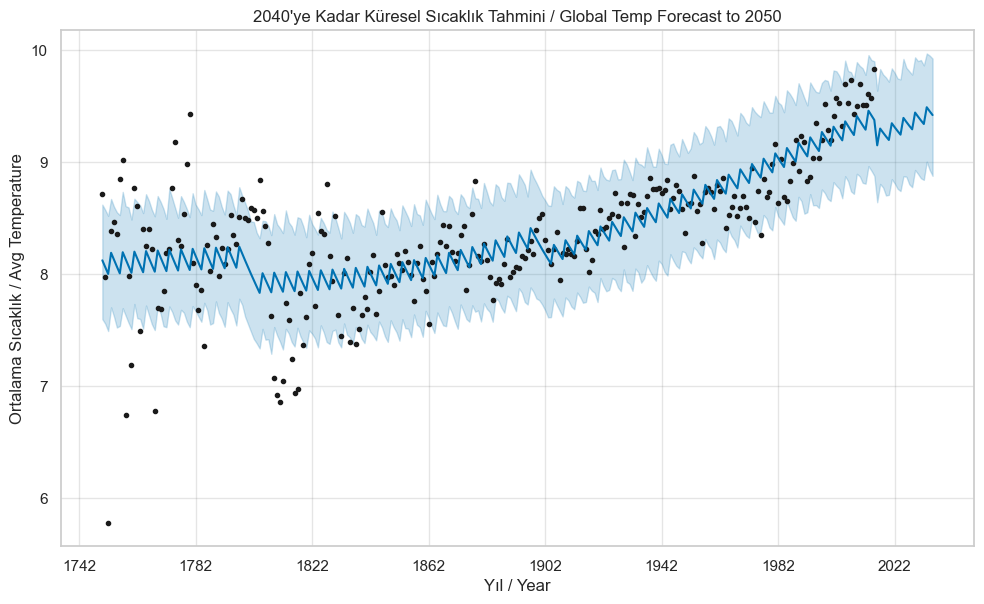

In [50]:
model.plot(forecast)
plt.title("2040'ye Kadar Küresel Sıcaklık Tahmini / Global Temp Forecast to 2050")
plt.xlabel("Yıl / Year")
plt.ylabel("Ortalama Sıcaklık / Avg Temperature")
plt.show()

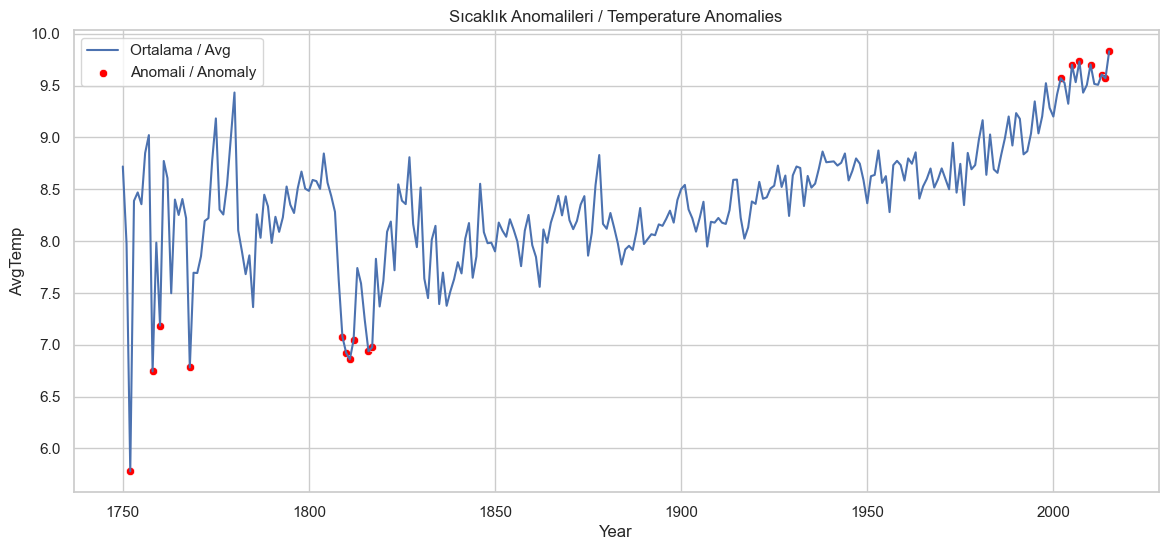

In [52]:
 # Z-score ile Anomali Tespiti / Anomaly Detection with Z-Score
yearly["zscore"] = (yearly["AvgTemp"] - yearly["AvgTemp"].mean()) / yearly["AvgTemp"].std()
yearly["anomaly"] = yearly["zscore"].apply(lambda x: 1 if abs(x) > 2 else 0)

sns.lineplot(x="Year", y="AvgTemp", data=yearly, label="Ortalama / Avg")
sns.scatterplot(x="Year", y="AvgTemp", data=yearly[yearly["anomaly"] == 1], color="red", label="Anomali / Anomaly")
plt.title("Sıcaklık Anomalileri / Temperature Anomalies")
plt.legend()
plt.show()

In [54]:
# 8. Sıcaklık Sınıflandırması / Temperature Classification (ML)
avg = yearly["AvgTemp"].mean()
yearly["Label"] = yearly["AvgTemp"].apply(lambda x: "Hot" if x > avg + 0.3 else ("Cold" if x < avg - 0.3 else "Normal"))

X_clf = yearly[["Year"]]
y_clf = yearly["Label"]

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X_clf, y_clf, test_size=0.2, random_state=42)
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [58]:
print("Sınıflandırma Raporu / Classification Report:")
print(classification_report(y_test, y_pred))

Sınıflandırma Raporu / Classification Report:
              precision    recall  f1-score   support

        Cold       0.73      0.79      0.76        14
         Hot       0.67      0.71      0.69        14
      Normal       0.75      0.69      0.72        26

    accuracy                           0.72        54
   macro avg       0.72      0.73      0.72        54
weighted avg       0.72      0.72      0.72        54



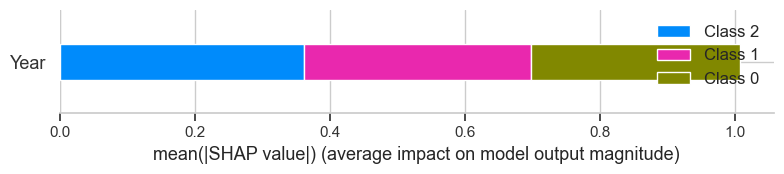

In [62]:
# SHAP ile Model Açıklama / Model Explainability with SHAP

explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_clf)

shap.summary_plot(shap_values, X_clf, plot_type="bar")